# Working Situation of Immigrants in Madrid 

In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Data preparation

In [2]:
data0 = pd.read_csv("../input/immigration-madrid-2021/Immigration_Madrid_2021.csv")
display(data0)

,Unnamed: 0,Gender,Age,Studies,Nationality,Administrative_situation,Working
0,0,Women,51-65,College,España,Community,No
1,1,Women,51-65,College,Venezuela,ART,No
2,2,Women,18-30,Pre-college,Honduras,Refugee,No
3,3,Women,18-30,Pre-college,Venezuela,Community,No
4,4,Women,18-30,Pre-college,República Dominicana,Community_familiar,No
...,...,...,...,...,...,...,...
1518,1803,Women,18-30,Elementary_school,España,Community,No
1519,1804,Women,18-30,Elementary_school,España,Community,No
1520,1805,Women,18-30,Elementary_school,Marruecos,Community,No
1521,1806,Women,18-30,Elementary_school,Marruecos,Community,No


In [3]:
display(data0['Working'].value_counts())

No     1417
Yes     106
Name: Working, dtype: int64

In [4]:
print(data0.columns.tolist())
Name=data0['Working'].unique().tolist()
N=[0,1]
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name))        
print(normal_mapping)
data0=data0.drop('Unnamed: 0',axis=1)
data0['Working']=data0['Working'].map(normal_mapping)

['Unnamed: 0', 'Gender', 'Age', 'Studies', 'Nationality', 'Administrative_situation', 'Working']
{'No': 0, 'Yes': 1}


In [5]:
from sklearn.preprocessing import LabelEncoder
def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object': 
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

In [6]:
data1=labelencoder(data0.copy())

In [7]:
m=len(data1)
print(m)
M=list(range(m))
random.seed(2020)
random.shuffle(M)

1523


# Target setting

In [8]:
target=['Working']
dataY=data1[target]
dataX=data1.drop(target,axis=1)

In [9]:
trainX=dataX.iloc[M[0:(m//5)*4]]
trainY=dataY.iloc[M[0:(m//5)*4]]
testX=dataX.iloc[M[(m//5)*4:]]
testY=dataY.iloc[M[(m//5)*4:]]

In [10]:
df_columns = list(trainX.columns)
print(df_columns)

['Gender', 'Age', 'Studies', 'Nationality', 'Administrative_situation']


In [11]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [12]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [13]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [14]:
train_feat_df = to_feature(trainX)
test_feat_df = to_feature(testX)

100%|██████████| 1/1 [00:00<00:00, 417.30it/s]


createcreate_numeric_feature  0.001[s]


100%|██████████| 1/1 [00:00<00:00, 553.70it/s]

createcreate_numeric_feature  0.001[s]


# Model

In [15]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [16]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [17]:
y = trainY
ydf=pd.DataFrame(y)
ydf

,Working
135,0
465,1
121,0
995,0
1142,0
...,...
637,0
1159,0
1045,0
96,0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

fit fold=0  0.138[s]
Fold 0 RMSLE: 0.2362

fit fold=1  0.060[s]
Fold 1 RMSLE: 0.2401

fit fold=2  0.085[s]
Fold 2 RMSLE: 0.2447



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecat

fit fold=3  0.066[s]
Fold 3 RMSLE: 0.2729

fit fold=4  0.066[s]
Fold 4 RMSLE: 0.2396

--------------------------------------------------
FINISHED | Whole RMSLE: 0.2470


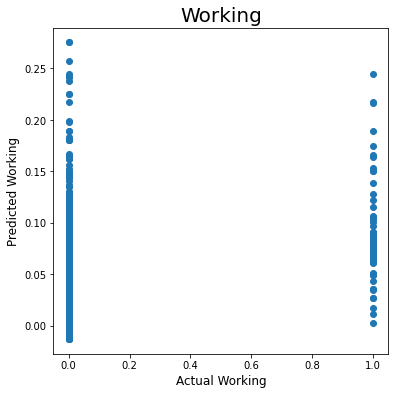

In [18]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_xlabel('Actual Working',fontsize=12)
    ax.set_ylabel('Predicted Working',fontsize=12)
    ax.scatter(y,oof)


# Visualize Importance

In [19]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

#fig, ax = visualize_importance(models, train_feat_df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

fit fold=0  0.077[s]
Fold 0 RMSLE: 0.2362

fit fold=1  0.057[s]
Fold 1 RMSLE: 0.2401

fit fold=2  0.084[s]
Fold 2 RMSLE: 0.2447



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecat

fit fold=3  0.069[s]
Fold 3 RMSLE: 0.2729

fit fold=4  0.058[s]
Fold 4 RMSLE: 0.2396

--------------------------------------------------
FINISHED | Whole RMSLE: 0.2470


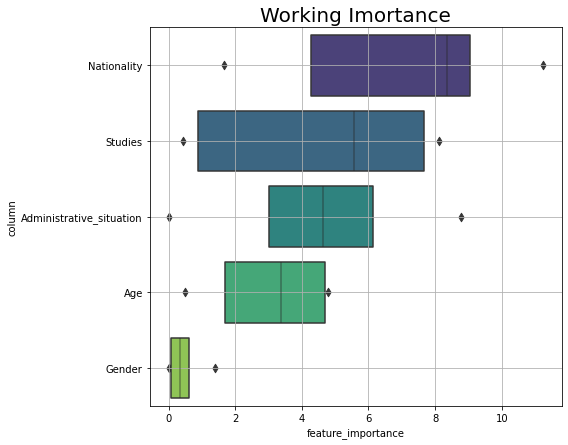

In [20]:
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)

In [21]:
pred0 = np.array([model.predict(test_feat_df.values) for model in models])
print(pred0.shape)
pred1=pred0.reshape(-1,5)
print(pred1.shape)

(5, 307)
(307, 5)


In [22]:
pred2=[]
for item in pred1:
    pred2+=[round(np.mean(item),0)]
    
ans=[]
for i in range(len(testY)):
    ans+=[testY.iloc[i,0]]

In [23]:
print(classification_report(ans,pred2,target_names=Name))

              precision    recall  f1-score   support

          No       0.92      1.00      0.96       282
         Yes       0.00      0.00      0.00        25

    accuracy                           0.92       307
   macro avg       0.46      0.50      0.48       307
weighted avg       0.84      0.92      0.88       307



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
data0

,Gender,Age,Studies,Nationality,Administrative_situation,Working
0,Women,51-65,College,España,Community,0
1,Women,51-65,College,Venezuela,ART,0
2,Women,18-30,Pre-college,Honduras,Refugee,0
3,Women,18-30,Pre-college,Venezuela,Community,0
4,Women,18-30,Pre-college,República Dominicana,Community_familiar,0
...,...,...,...,...,...,...
1518,Women,18-30,Elementary_school,España,Community,0
1519,Women,18-30,Elementary_school,España,Community,0
1520,Women,18-30,Elementary_school,Marruecos,Community,0
1521,Women,18-30,Elementary_school,Marruecos,Community,0


In [25]:
data2=data0[['Nationality','Working']]
data3=data2.groupby('Nationality',as_index=False).mean().sort_values('Working',ascending=False)
display(data3[0:20])

,Nationality,Working
36,República de Corea,0.400000
17,Gambia,0.333333
39,Sahara,0.250000
19,Guinea,0.166667
45,Venezuela,0.147541
8,China,0.142857
26,Malí,0.125000
44,Ucrania,0.111111
28,Nicaragua,0.103448
29,Nigeria,0.100000


In [26]:
fig = px.bar(data3[:20], x='Nationality', y='Working',title="Working Situation Ranking by Nationality")
fig.show()